In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pickle
import sys, os, time

sys.path.append(os.path.abspath("../../src"))
from SegLabel_DataClass import SegLabel
from common import get_counts, linear_ramp_params_customized

In [2]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance

## Model

In [3]:
from SegmentationAndLabeling_NEW_VERSION import SegmentationAndLabeling

# read the data
with open("018340451_hipster_SegLabelData.pickle", "rb") as f:
    segLabel = pickle.load(f)

# beta_dc_d'c'u
B = segLabel.betas.copy()
B = np.nan_to_num(B, nan=0.0)
B_max = np.max(B)

print("B:")
print("  shape: ", np.shape(B))
print("  min/max: ", np.min(B), B_max)

# alpha_dc
A = segLabel.alphas.copy()
A = np.nan_to_num(A, nan=0.0)
A_max = B_max
A[A > A_max] = A_max  # truncate too high values

print("A:")
print("  shape: ", np.shape(A))
print("  min/max: ", np.min(A), np.max(A))
print("")

max_num_segments = segLabel.max_num_persons
suppress = False

model = SegmentationAndLabeling(
    A=A, B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress
)

B:
  shape:  (4, 4, 2, 2)
  min/max:  -2.0 26.0
A:
  shape:  (4, 2)
  min/max:  -6.0 26.0

Segmentation and Labeling Problem initialization:
  Number of nodes:  4
  Number of labels:  2
  Maximum number of segments:  2


### Classical (reference) solution

In [4]:
C = B_max

# Build the DOcplex model of the S&L problem
mdl = model.build_model(C=C)  # enable constraints
mdl.solve()
mdl.print_information()
mdl.print_solution()

x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value
# print(x)

obj_exact = mdl.objective_value
x_exact = x

automatic C=max(B)= 26.0
Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -15.000
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1


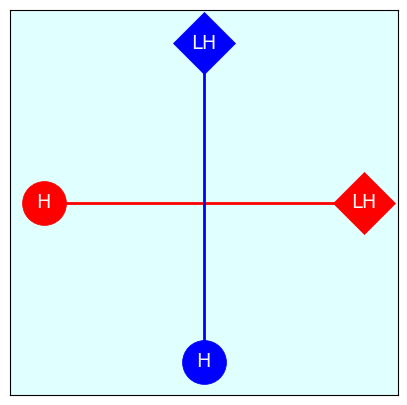

In [5]:
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    x_exact,
    node_size=1000,
    width=2,
    alpha=1.0,
)

plt.show()

### QUBO matrix setup

In [6]:
mdl_qp = from_docplex_mp(mdl)
# print(mdl_qp.prettyprint())

mdl_qubo = QuadraticProgramToQubo().convert(mdl_qp)

qubitOp, offset = mdl_qubo.to_ising()

if True:
    # normalize the Hamiltonian
    w_max = np.max(np.abs(qubitOp.primitive.coeffs))
    qubitOp.primitive.coeffs /= w_max
    offset /= w_max

print("Offset:", offset)
# print("Ising Hamiltonian:\n", str(qubitOp))

Offset: 7.163934426229508


In [7]:
# QUBO matrix info
q2 = mdl_qubo.objective.quadratic.to_dict()
num_qubits = qubitOp.num_qubits
num_q2 = len(q2) - num_qubits
print("Number of quadratic terms: ", num_q2)
print("QUBO matrix sparsity: ", num_q2 / (num_qubits * (num_qubits - 1) * 0.5))

Number of quadratic terms:  70
QUBO matrix sparsity:  0.5833333333333334


## QAOA

In [8]:
n_shots = 1024

seed = 12345
algorithm_globals.random_seed = seed
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

In [9]:
from mixers import x_mixer_initial_state

initial_state = x_mixer_initial_state(qubitOp.num_qubits)
# print(initial_state.draw())

In [10]:
from mixers import x_mixer

mixer = x_mixer(qubitOp.num_qubits)
# print(mixer.draw())

In [16]:
reps = 8

qc = QAOAAnsatz(
    qubitOp, reps=reps, 
    initial_state=initial_state, 
    mixer_operator=mixer
)

init_params = linear_ramp_params_customized(p=reps, beta_scale=0.5, gamma_scale=2.0)
print("Initial parameters: ", params)

qaoa = VQE(
    ansatz=qc,
    quantum_instance=quantum_instance,
    optimizer=COBYLA(maxiter=1000, tol=1e-4),
    initial_point=init_params,
)

qaoa_results = qaoa.compute_minimum_eigenvalue(qubitOp)

params = list(qaoa_results.optimal_parameters.values())
print("Optimized parameters: ", params)

Initial parameters:  [0.46875 0.40625 0.34375 0.28125 0.21875 0.15625 0.09375 0.03125 0.125
 0.375   0.625   0.875   1.125   1.375   1.625   1.875  ]
Optimized parameters:  [0.500074758513164, 0.5262269479977323, 0.32041662085724343, 0.23573905116253235, 0.17939729570557375, 0.13926703396680018, 0.13537516719735967, 0.07447730405564917, 0.16584762863747096, 0.337924431156343, 0.621910222976358, 0.882119828654567, 1.146469673723236, 1.4153089077664085, 1.6241089475561128, 1.8831654594996008]


In [21]:
n_reads = 10_000

# QAOA circuit sampler
counts = get_counts(
    qc,
    params,
    backend=backend,
    n_shots=n_reads,
    seed=seed,
)

sols = []
for s, p in counts.items():
    x = [int(i) for i in reversed(list(s))]
    obj = mdl_qubo.objective.evaluate(x)
    sols.append({"x": x, "prob": p / n_reads, "obj": obj, "feas": model.is_valid(x)})
sols = sorted(sols, key=lambda k: k["obj"]) # sort by objective values

# compute success probability
sprob = np.sum([item['prob'] for item in sols if np.isclose(item['obj'], obj_exact)])
print("Success probability: ", sprob)

Success probability:  0.1119


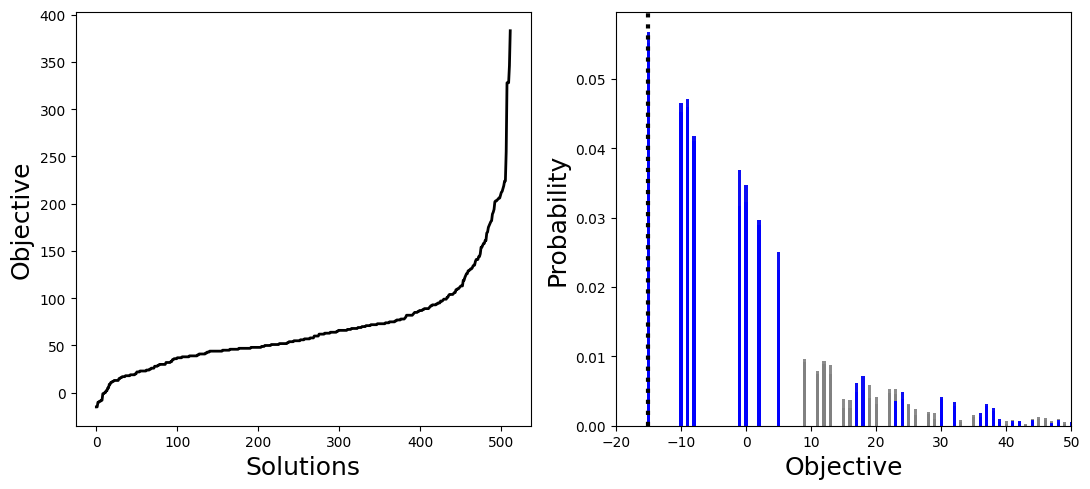

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

objs = [v["obj"] for v in sols]
probs = [v["prob"] for v in sols]

objs_feas = [v["obj"] for v in sols if v["feas"]]
probs_feas = [v["prob"] for v in sols if v["feas"]]

ax[0].plot(objs, c="k", lw=2, label="neal")
ax[0].set_xlabel("Solutions", fontsize=18)
ax[0].set_ylabel("Objective", fontsize=18)

width = 0.5
ax[1].bar(objs, probs, width=width, color="grey", alpha=0.9)
ax[1].bar(objs_feas, probs_feas, width=width, color="b", alpha=0.9)
ax[1].set_xlabel("Objective", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)

ax[1].axvline(x=obj_exact, c="k", ls=":", lw=3)
ax[1].set_xlim([-20, 50])

plt.tight_layout()
plt.show()

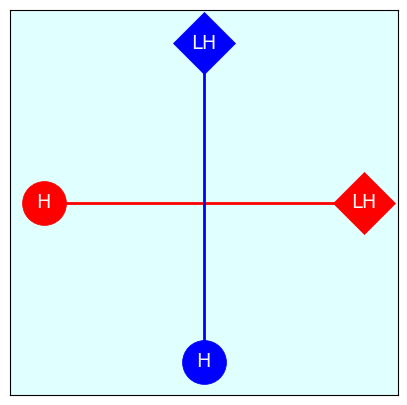

In [20]:
fig = plt.figure(figsize=(5, 5), frameon=False)
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index
ax.set_facecolor("lightcyan")

model.draw_solution(
    ax,
    sols[0]['x'],
    node_size=1000,
    width=2,
    alpha=1.0,
)

plt.show()